In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm

# Loading and EDA

In [2]:
# Paths to your JSONL files
reviews_path = "Digital_Music_reviews.jsonl"
meta_path = "Digital_Music_meta.jsonl"

# Load review dataset
reviews = []
with open(reviews_path, "r", encoding="utf-8") as f:
    for line in f:
        reviews.append(json.loads(line))
reviews_df = pd.DataFrame(reviews)

reviews_df.head(2)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Nice,If i had a dollar for how many times I have pl...,[],B004RQ2IRG,B004RQ2IRG,AFUOYIZBU3MTBOLYKOJE5Z35MBDA,1618972613292,0,True
1,5.0,Excellent,awesome sound - cant wait to see them in perso...,[],B0026UZEI0,B0026UZEI0,AHGAOIZVODNHYMNCBV4DECZH42UQ,1308167525000,0,True


In [3]:
# Load meta dataset
meta = []
with open(meta_path, "r", encoding="utf-8") as f:
    for line in f:
        meta.append(json.loads(line))
meta_df = pd.DataFrame(meta)

print("Reviews shape:", reviews_df.shape)
print("Meta shape:", meta_df.shape)

meta_df.head(2)

Reviews shape: (130434, 10)
Meta shape: (70537, 14)


,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,Digital Music,Baja Marimba Band,4.9,8,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],None,[],"{'Date First Available': 'February 28, 2010'}",B000V87RP2,None
1,Digital Music,'80s Halloween-All Original Artists & Recordings,5.0,3,[],[],14.98,[{'thumb': 'https://m.media-amazon.com/images/...,[],"Love and Rockets (Artist), Duran Duran (...",[],{'Package Dimensions': '5.55 x 4.97 x 0.54 inc...,B0062F0MJQ,None


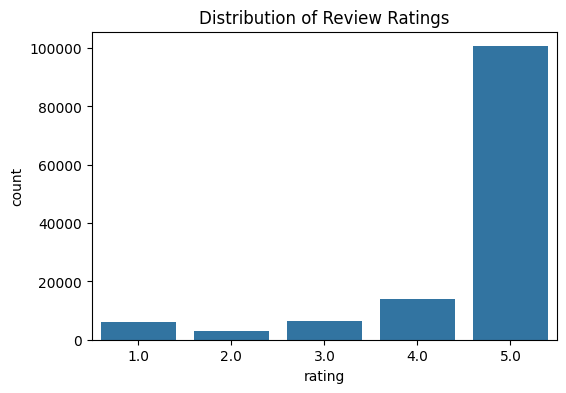

In [4]:
# Rating distribution
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=reviews_df)
plt.title("Distribution of Review Ratings")
plt.show()

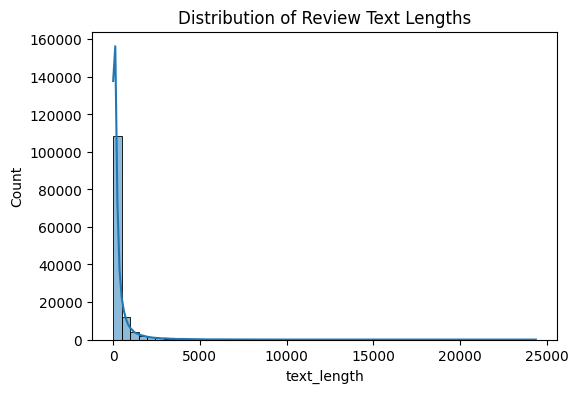

In [5]:
# Review length distribution
reviews_df['text_length'] = reviews_df['text'].astype(str).apply(len)
plt.figure(figsize=(6,4))
sns.histplot(reviews_df['text_length'], bins=50, kde=True)
plt.title("Distribution of Review Text Lengths")
plt.show()

In [6]:
reviews_df[['rating','text_length']].describe()

,rating,text_length
count,130434.000000,130434.000000
mean,4.532837,340.236280
std,1.027994,748.095233
min,1.000000,0.000000
25%,5.000000,43.000000
50%,5.000000,124.000000
75%,5.000000,319.000000
max,5.000000,24366.000000


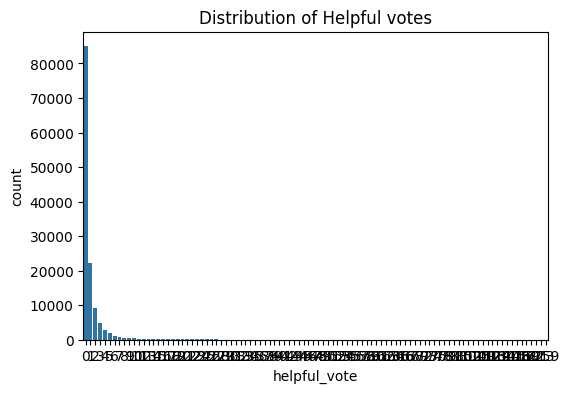

In [7]:
# Rating distribution
plt.figure(figsize=(6,4))
sns.countplot(x='helpful_vote', data=reviews_df)
plt.title("Distribution of Helpful votes")
plt.show()

In [16]:
reviews_df.query("text_length > 50").shape[0]

93547

In [14]:
reviews_df.shape[0]

130434

# Cleaning

In [17]:
reviews_df = reviews_df[reviews_df['text'].notnull() & (reviews_df['text'].str.strip() != '')]

# Clean text
def clean_text(t):
    t = re.sub(r'http\S+', '', t)              # remove URLs
    t = re.sub(r'[^A-Za-z0-9.,!?\'\s]', '', t) # remove non-alphanumeric
    t = re.sub(r'\s+', ' ', t).strip()         # remove extra spaces
    return t

tqdm.pandas()
reviews_df['clean_text'] = reviews_df['text'].progress_apply(clean_text)

# Keep only useful columns
reviews_df = reviews_df[['parent_asin', 'rating', 'title', 'clean_text', 'helpful_vote', 'verified_purchase']]
reviews_df.rename(columns={'clean_text':'review_text'}, inplace=True)
reviews_df.head()

100%|███████████████████████████████████████████████████████████████████████| 130384/130384 [00:03<00:00, 37877.64it/s]
C:\Users\kotha\AppData\Local\Temp\ipykernel_13468\2857905506.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['clean_text'] = reviews_df['text'].progress_apply(clean_text)


,parent_asin,rating,title,review_text,helpful_vote,verified_purchase
0,B004RQ2IRG,5.0,Nice,If i had a dollar for how many times I have pl...,0,True
1,B0026UZEI0,5.0,Excellent,awesome sound cant wait to see them in person ...,0,True
2,B0055JSYHC,5.0,Great service,This is a great cd. Good music and plays well....,0,True
3,B000F9SMUQ,1.0,No good,"These are not real German singers, they have a...",0,True
4,B0049D1WVK,3.0,"Cool concept, so-so execution...",I first heard this playing in a Nagoya shop an...,0,False


In [18]:
meta_df = meta_df[['parent_asin', 'title', 'average_rating']].dropna(subset=['parent_asin'])
meta_df.rename(columns={'title':'product_title'}, inplace=True)
meta_df.head()

,parent_asin,product_title,average_rating
0,B000V87RP2,Baja Marimba Band,4.9
1,B0062F0MJQ,'80s Halloween-All Original Artists & Recordings,5.0
2,B00005GT12,TRIO +1,5.0
3,B0007PD2BW,"Gold and Silver: Lehar, Delibes, Lanner, Johan...",5.0
4,B079CPD45R,Grateful Dead Dave's Picks Volume 25 Live at B...,4.9


In [19]:
merged_df = pd.merge(reviews_df, meta_df, on='parent_asin', how='left')
print("Merged dataset shape:", merged_df.shape)
merged_df.head(3)

Merged dataset shape: (130384, 8)


,parent_asin,rating,title,review_text,helpful_vote,verified_purchase,product_title,average_rating
0,B004RQ2IRG,5.0,Nice,If i had a dollar for how many times I have pl...,0,True,Good Things,4.5
1,B0026UZEI0,5.0,Excellent,awesome sound cant wait to see them in person ...,0,True,Sugar Red Drive,5.0
2,B0055JSYHC,5.0,Great service,This is a great cd. Good music and plays well....,0,True,Body + Soul: The '70s (Time-Life),4.8


In [20]:
# Drop rows without product title
merged_df = merged_df.dropna(subset=['product_title'])

# Remove duplicates
merged_df.drop_duplicates(subset=['parent_asin','review_text'], inplace=True)

# Overview
print(merged_df.info())
print(merged_df.describe(include='all').T.head())

# Number of unique products
print("Unique Products:", merged_df['parent_asin'].nunique())


<class 'pandas.core.frame.DataFrame'>
Index: 128641 entries, 0 to 130383
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   parent_asin        128641 non-null  object 
 1   rating             128641 non-null  float64
 2   title              128641 non-null  object 
 3   review_text        128641 non-null  object 
 4   helpful_vote       128641 non-null  int64  
 5   verified_purchase  128641 non-null  bool   
 6   product_title      128641 non-null  object 
 7   average_rating     128641 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(4)
memory usage: 8.0+ MB
None
                 count  unique         top   freq      mean       std  min  \
parent_asin     128641   70497  B00003CXKT    397       NaN       NaN  NaN   
rating        128641.0     NaN         NaN    NaN  4.535685  1.024166  1.0   
title           128641   85970  Five Stars  17068       NaN       NaN  NaN   
review_text     1

In [22]:
grouped_df = merged_df.groupby(['parent_asin', 'product_title', 'average_rating']).agg({
    'review_text': lambda x: ' '.join(x),
    'rating': 'mean',
    'helpful_vote': 'sum'
}).reset_index()

grouped_df.rename(columns={'rating':'avg_user_rating'}, inplace=True)

print("Grouped dataset shape:", grouped_df.shape)
grouped_df.head(2)

Grouped dataset shape: (70497, 6)


,parent_asin,product_title,average_rating,review_text,avg_user_rating,helpful_vote
0,0001046314,A Woman of Substance,4.6,Great for a quick tape of the best Bradford bo...,4.0,0
1,0001046519,The Importance of Being Earnest Complete & Una...,4.5,"Oscar Wilde's masterpiece, this play has many,...",5.0,1


In [23]:
# Save both — merged (all reviews) and grouped (per product)
merged_df.to_csv("merged_reviews.csv", index=False)
grouped_df.to_csv("grouped_reviews.csv", index=False)